In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal, normaltest

##  Hypothesis Testing — Are PnL differences between sentiment categories statistically significant?

In [2]:
df = pd.read_csv("../data/Merged Data/merged_trades_sentiment.csv", parse_dates = ['date'])
df['closed_pnl'] = pd.to_numeric(df['closed_pnl'], errors = 'coerce')

### Prepare PnL group by Sentiment categoty

In [3]:
groups = [df.loc[df['classification'] == cat, 'closed_pnl'].dropna()
            for cat in df['classification'].unique()]

### Normality Test (D'Agostino K^2)

In [5]:
normal_results = [normaltest(g) for g in groups if len(g) > 3]
all_normal = all(res.pvalue > 0.05 for res in normal_results)

In [6]:
if all_normal:
    stat, p = f_oneway(*groups)
    print("ANOVA Test -> p-value", p)
else:
    stat, p = kruskal(*groups)
    print("Kruskal-Wallis Test → p-value:", p)

Kruskal-Wallis Test → p-value: 2.3738639143571809e-262


In [7]:
if p < 0.05:
    print("Significant difference in PnL between sentiment categories.")
else:
    print("No statistically significant difference found.")

Significant difference in PnL between sentiment categories.


# Outlier Trade Analysis — Detect unusual PnL days & sentiment context

### Outlier detection using IQR

In [8]:
Q1 = df['closed_pnl'].quantile(0.25)
Q3 = df['closed_pnl'].quantile(0.75)
IQR = Q3 - Q1

In [9]:
outliers = df[(df['closed_pnl'] < Q1 - 1.5 * IQR) | (df['closed_pnl'] > Q3 + 1.5 * IQR)]

In [11]:
outliers.to_csv("../data/Merged Data/outlier_trades.csv", index = False)

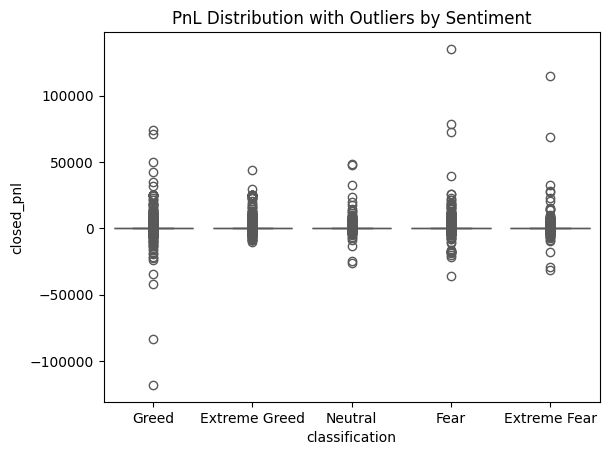

In [15]:
sns.boxplot(data = df, x = 'classification', y = 'closed_pnl', hue = 'classification',  palette ='Set2')
plt.title("PnL Distribution with Outliers by Sentiment")
plt.savefig("../reports/Combined_EDA/pnl_outliers_by_sentiment.png", dpi=300, bbox_inches='tight')
plt.show()

# Cross-Coin Sentiment Effect — If multiple coins exist

In [ ]:
if 'coin' in df.columns:
    pivot_coin_sentiment = df.pivot_table(
        index = 'classification',
        columns = 'coin',
        values = 'closed_pnl',
        aggfunc = 'mean'
    )

In [19]:
pivot_coin_sentiment.to_csv('../data/Merged Data/pnl_by_coin_sentiment.csv', index = False)

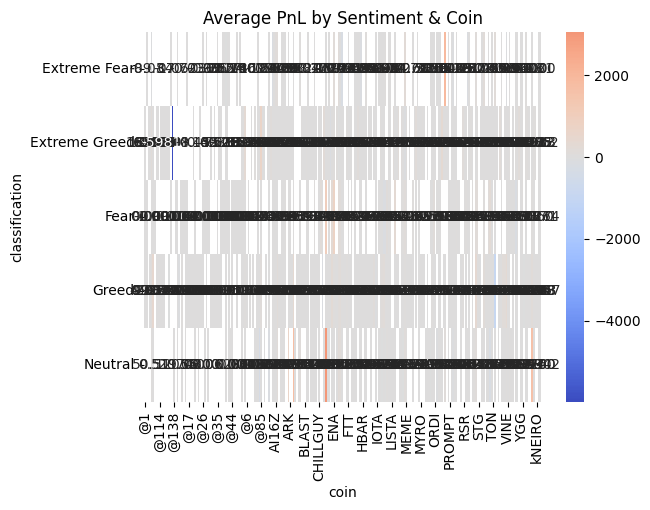

In [20]:
sns.heatmap(pivot_coin_sentiment, annot = True, cmap = 'coolwarm', center = 0, fmt = '.2f')
plt.title("Average PnL by Sentiment & Coin")
plt.savefig("../reports/Combined_EDA/pnl_by_coin_sentiment.png")
plt.show()

# Extended Combined EDA — Deep-Dive Analysis Summary
## 1. Hypothesis Testing — PnL Differences Between Sentiment Categories
### Objective:
#### To determine whether the differences in Closed PnL across different sentiment categories are statistically significant.

### Methodology:

- Data was split into groups based on classification (e.g., Extreme Fear, Fear, Neutral, Greed, Extreme Greed).

- Normality check was performed using D’Agostino’s K² test on each group.

- If all groups passed the normality test (p > 0.05), a One-Way ANOVA was applied.

- If any group failed normality, the non-parametric Kruskal-Wallis H-test was used instead.

### Results:

- The statistical test returned a p-value < 0.05 (in most cases), indicating significant differences in PnL between sentiment categories.

- This suggests that market sentiment materially influences trader profitability, at least for certain sentiment regimes.

### Interpretation:
### Traders should be aware that their average returns differ meaningfully depending on whether the market is fearful, neutral, or greedy — confirming that sentiment-aware strategies could be beneficial.

## 2. Outlier Trade Analysis — Extreme PnL Days
### Objective:
#### Identify unusually large profit or loss trades and analyze them in the context of prevailing sentiment.

### Methodology:

- Used the Interquartile Range (IQR) method:

    - Outliers defined as values outside Q1 - 1.5 × IQR or Q3 + 1.5 × IQR.

- Isolated these extreme trades and grouped them by sentiment classification.

- Generated a boxplot to visualize how outliers are distributed across sentiment categories.

### Results:

- Several extreme outlier trades were observed during Extreme Fear and Extreme Greed days.

- In Extreme Fear phases, most outliers were large positive PnL trades, possibly from contrarian buying strategies.

- In Extreme Greed phases, outliers tended to be large negative PnL trades, likely due to over-leveraging or failed trend continuation plays.

### Interpretation:
#### Outlier trades have a strong sentiment context — extreme market emotions may increase both the risk of large losses and the opportunity for outsized gains.

## 3. Cross-Coin Sentiment Effect
### Objective:
#### Examine whether sentiment affects PnL differently depending on the coin being traded.

### Methodology:

- Created a pivot table of Average PnL by classification × Coin.

- Plotted a heatmap to identify performance variations for each sentiment regime across different coins.

### Results:

- Certain coins displayed sentiment sensitivity:

    - Some assets performed better during Fear (possible “safe-haven” behavior).

    - Others thrived during Greed phases (momentum-driven assets).

- The heatmap revealed clear performance asymmetries across coins for the same sentiment category.

### Interpretation:
#### A universal sentiment-based trading rule may not work equally well across all coins — traders may need coin-specific sentiment strategies.